In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calibration_08302023 as cal
import sys
sys.path.append('../../')
from utils import *
from fears.utils import AutoRate
import scipy.stats as stats

rfu30_to_dilution = cal.run()

data_file = '../experiment_data/DNase_exp_t.csv'

df = pd.read_csv(data_file, header=0)
df['Cell Count 10^4'] = df['Cell Count 10^4']*10**4/50
df['Cell Count 10^5'] = df['Cell Count 10^5']*10**5/50

In [96]:
# AB background estimation

ab_folder = '../experiment_data/DNAse_exp_ab'

files = os.listdir(ab_folder)
files = [f for f in files if f.endswith('.xlsx')
         and not f.startswith('.')]
files.sort(key=natural_keys)

file_path = os.path.join(ab_folder,files[2])

p = AutoRate.Plate(file_path,mode='single_measurement')

data = p.od_data_to_dict(p.data)

rows = ['B','C','D','E','F','G']

col = 11

bg_est = []
for row in rows:
    key = row + str(col)
    bg_est.append(data[key])

bg_est = np.mean(bg_est)

In [97]:
# load AB data

replicates = ['C','D','E']

cols = ['5','6','7']

rfu_dict = {'mean':[],
            'err':[]}
cell_count_dict = {'mean':[],
                   'err':[],
                   'log_mean':[],
                   'log_err':[]}

time_list = []

for i,col in enumerate(cols):
    file = files[i]
    file_path = os.path.join(ab_folder,file)
    p = AutoRate.Plate(file_path,mode='single_measurement')
    data = p.od_data_to_dict(p.data)

    time_list.append(p.get_start_time())

    rfu_t = []
    for row in replicates:
        key = row+col
        rfu_t.append(data[key]-bg_est)
    
    cell_count_t = rfu30_to_dilution(rfu_t,background_subtracted=True)

    cell_count_log = np.log10(cell_count_t)

    rfu_dict['mean'].append(np.mean(rfu_t))
    rfu_dict['err'].append(np.std(rfu_t)/np.sqrt(len(rfu_t)))
    cell_count_dict['mean'].append(np.mean(cell_count_t))
    cell_count_dict['err'].append(np.std(cell_count_t)/np.sqrt(len(cell_count_t)))
    cell_count_dict['log_mean'].append(np.mean(cell_count_log))
    cell_count_dict['log_err'].append(np.std(cell_count_log)/np.sqrt(len(cell_count_log)))

time = []

t0 = time_list[0]
for t in time_list:
    time.append((t-t0).total_seconds()/60)

time = np.array(time)
time = time + 65

cell_count_dict['time'] = time

Text(0, 0.5, 'Cell Count (uL$^{-1}$)')

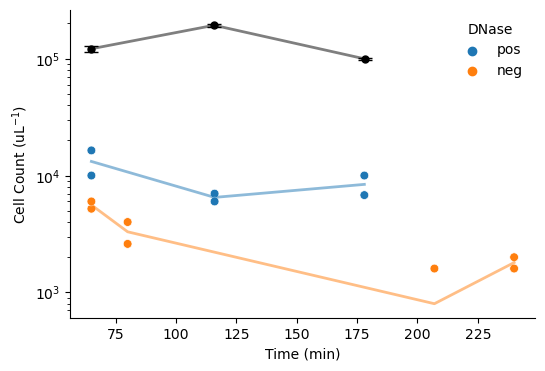

In [98]:
fig,ax = plt.subplots(figsize=(6,4))

s = 40

ax = sns.scatterplot(y='Cell Count 10^4', x='Time', data=df, hue='DNase', legend=True, ax=ax,s=s)
ax = sns.scatterplot(y='Cell Count 10^5', x='Time', data=df, hue='DNase', legend=True, ax=ax,s=s)

df['mean'] = df[['Cell Count 10^4','Cell Count 10^5']].mean(axis=1)

ax = sns.lineplot(y='mean', x='Time', data=df, hue='DNase', legend=False, ax=ax, alpha=0.5,linewidth=2)

ax.errorbar(cell_count_dict['time'],cell_count_dict['mean'],yerr=cell_count_dict['err'],fmt='o',color='black',capsize=5,elinewidth=2,markersize=5)
ax.plot(cell_count_dict['time'],cell_count_dict['mean'],color='black',linewidth=2,alpha=0.5)

ax.set_yscale('log')

# only plot unique legend entries

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), frameon=False,title='DNase')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Time (min)')
ax.set_ylabel('Cell Count (uL$^{-1}$)')


0.08200280651920021


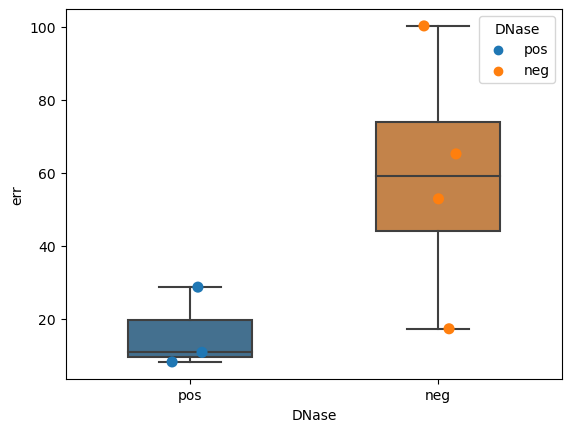

In [118]:
df['Cell Count AB'] = np.round(rfu30_to_dilution(df['RFU30']-bg_est,background_subtracted=True))

df['diff'] = df['Cell Count AB'] - df['mean']

df['err'] = (df['Cell Count AB'] - df['mean'])/df['mean']

df['ratio'] = df['mean']/df['Cell Count AB']


fig,ax = plt.subplots()

y = 'err'

ax = sns.stripplot(x='DNase',y=y,data=df,ax=ax,hue='DNase',s=8)

ax = sns.boxplot(x='DNase',y=y,data=df,ax=ax,width=0.5,saturation=0.5)

# ax.set_yscale('log')

# perform t-test

res = stats.ttest_ind(df[df['DNase']=='pos'][y],df[df['DNase']=='neg'][y],equal_var=False,alternative='two-sided')
print(res.pvalue)
# ax.set_title(y)